In [1]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('wine-quality').getOrCreate()

In [2]:
red = spark.read.option("delimiter", ";").csv('./winequality-red.csv', header='true', inferSchema='true')
# white = spark.read.option("delimiter", ";").csv('./winequality-white.csv', header='true', inferSchema='true')

red.printSchema()
# red.show()
display(red)

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

In [3]:
train, test = red.randomSplit([0.8, 0.2])
train.count()
test.count()

322

In [4]:
from pyspark.sql.functions import kurtosis, skewness

labelCol = 'quality'

train.select(labelCol).describe().show()
train.groupby(labelCol).count().orderBy(labelCol).show()

train.agg(skewness(labelCol)).show()
train.agg(kurtosis(labelCol)).show()
# Last parameter is error tolerance
quantile = train.approxQuantile(labelCol, [0.25, 0.50, 0.75], 0.05)
quantileFrame = spark.createDataFrame([quantile], ['25%', '50%', '75%'])
quantileFrame.show()
# train.stat.freqItems([labelCol], 0.1).show()

+-------+------------------+
|summary|           quality|
+-------+------------------+
|  count|              1277|
|   mean|  5.63664839467502|
| stddev|0.8168507723388285|
|    min|                 3|
|    max|                 8|
+-------+------------------+

+-------+-----+
|quality|count|
+-------+-----+
|      3|    9|
|      4|   42|
|      5|  545|
|      6|  506|
|      7|  158|
|      8|   17|
+-------+-----+

+-------------------+
|  skewness(quality)|
+-------------------+
|0.22919685924363212|
+-------------------+

+------------------+
| kurtosis(quality)|
+------------------+
|0.3663046154584193|
+------------------+

+---+---+---+
|25%|50%|75%|
+---+---+---+
|5.0|5.0|6.0|
+---+---+---+



In [5]:
f = train.groupby('citric acid').count().orderBy('count')
display(f)

DataFrame[citric acid: double, count: bigint]

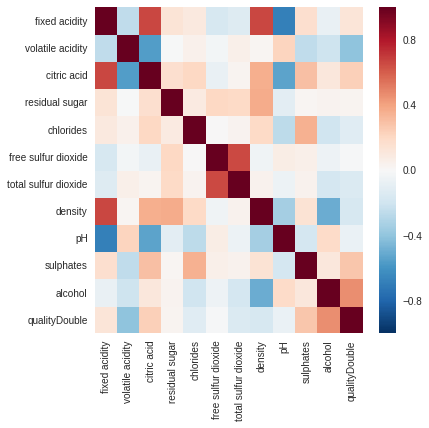

In [6]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

changedTrain = train.withColumn(labelCol+'Double', train[labelCol].cast("double")).drop(labelCol)

# numericCols = [dtype[0] for dtype in train.dtypes if dtype[1] == 'double']
numericCols = changedTrain.columns

corrAssembler = VectorAssembler(inputCols=numericCols, outputCol='corrFeatures')
corrTrain = corrAssembler.transform(changedTrain)
corrMat = Correlation.corr(corrTrain, 'corrFeatures').head()

pdf = corrMat[0].toArray()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

sns.heatmap(pdf, 
            xticklabels=numericCols,
            yticklabels=numericCols)

In [7]:
%%script false
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

cols = train.columns[:]
cols.remove(labelCol)

assembler = VectorAssembler(inputCols=cols, outputCol="assembledFeatures")
scalers = StandardScaler(inputCol="assembledFeatures", outputCol="features", withStd=True, withMean=True)
pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")
pipeline = Pipeline(stages=[assembler, scalers, pca])
model = pipeline.fit(train)
pcaTrain = model.transform(train)
pcaTrain.select("features", "pcaFeatures").show()

There's some moderate correlation between 'citric acid' and 'fixed acidity', 'free sulfur dioxide' and 'total sulfur dioxide', 'fixed acidity' and 'density'

In [8]:
train

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

# Classifiers

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

accuracyDataFrame = pd.DataFrame(columns=['Train', 'Test'])

## Regressor

In [10]:
%%script false 
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

cols = train.columns[:]
cols.remove(labelCol)

gbtRegressorTrain = train

assembler = VectorAssembler(inputCols=cols, outputCol='features')
regressor = GBTRegressor(labelCol='quality')
pipeline = Pipeline(stages=[assembler, regressor])
grid = ParamGridBuilder().addGrid(regressor.maxIter, [5, 10, 15]).build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = RegressionEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(gbtRegressorTrain)
gbtRegressorTrain = model.transform(gbtRegressorTrain)
gbtRegressorTest = model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

print(evaluator.evaluate(gbtRegressorTrain, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(gbtRegressorTest, {evaluator.metricName: "accuracy"}))


## RandomForestClassifier

In [11]:
from pyspark.ml.classification import RandomForestClassifier

cols = train.columns[:]
cols.remove(labelCol)

randomForestClassifierTrain = train
randomForestClassifierTest = test

assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = RandomForestClassifier(labelCol='quality')
pipeline = Pipeline(stages=[assembler, classifier])
grid = ParamGridBuilder().addGrid(classifier.maxDepth, [5, 10])\
                         .addGrid(classifier.numTrees, [10, 15])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(randomForestClassifierTrain)
randomForestClassifierTrain = model.transform(randomForestClassifierTrain)
randomForestClassifierTest = model.transform(randomForestClassifierTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(randomForestClassifierTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(randomForestClassifierTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['RandomForestClassifier'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
RandomForestClassifier,0.927956,0.673913


In [12]:
from pyspark.ml.classification import LogisticRegression

cols = train.columns[:]
cols.remove(labelCol)

logisticRegressionTrain = train
logisticRegressionTest = test

assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = LogisticRegression(labelCol='quality')
pipeline = Pipeline(stages=[assembler, classifier])
grid = ParamGridBuilder().addGrid(classifier.regParam, [0.1, 0.15])\
                         .addGrid(classifier.maxIter, [100, 200, 300])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(logisticRegressionTrain)
logisticRegressionTrain = model.transform(logisticRegressionTrain)
logisticRegressionTest = model.transform(logisticRegressionTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(logisticRegressionTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(logisticRegressionTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['LogisticRegression'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
RandomForestClassifier,0.927956,0.673913
LogisticRegression,0.581049,0.580745


## MultilayerPerceptronClassifier

In [13]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

cols = train.columns[:]
cols.remove(labelCol)

multilayerPerceptronClassifierTrain = train
multilayerPerceptronClassifierTest = test

assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = MultilayerPerceptronClassifier(labelCol='quality')
pipeline = Pipeline(stages=[assembler, classifier])
grid = ParamGridBuilder().addGrid(classifier.maxIter, [100, 200])\
                         .addGrid(classifier.layers, [[11, 10, 6], [11, 20, 6]])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(multilayerPerceptronClassifierTrain)
multilayerPerceptronClassifierTrain = model.transform(multilayerPerceptronClassifierTrain)
multilayerPerceptronClassifierTest = model.transform(multilayerPerceptronClassifierTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(multilayerPerceptronClassifierTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(multilayerPerceptronClassifierTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['MultilayerPerceptronClassifier'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

Py4JJavaError: An error occurred while calling o27383.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 14614.0 failed 1 times, most recent failure: Lost task 0.0 in stage 14614.0 (TID 14818, localhost, executor driver): java.lang.ArrayIndexOutOfBoundsException: 6
	at org.apache.spark.ml.classification.LabelConverter$.encodeLabeledPoint(MultilayerPerceptronClassifier.scala:119)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier$$anonfun$3.apply(MultilayerPerceptronClassifier.scala:244)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier$$anonfun$3.apply(MultilayerPerceptronClassifier.scala:244)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1076)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1091)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1128)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:216)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1092)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1018)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:809)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1162)
	at org.apache.spark.mllib.optimization.LBFGS$.runLBFGS(LBFGS.scala:195)
	at org.apache.spark.mllib.optimization.LBFGS.optimize(LBFGS.scala:142)
	at org.apache.spark.ml.ann.FeedForwardTrainer.train(Layer.scala:854)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:266)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:143)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.GeneratedMethodAccessor136.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.ArrayIndexOutOfBoundsException: 6
	at org.apache.spark.ml.classification.LabelConverter$.encodeLabeledPoint(MultilayerPerceptronClassifier.scala:119)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier$$anonfun$3.apply(MultilayerPerceptronClassifier.scala:244)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier$$anonfun$3.apply(MultilayerPerceptronClassifier.scala:244)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1076)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1091)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1128)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:216)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1092)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1018)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:809)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [39]:
from pyspark.ml.pipeline import Estimator, Model, Pipeline
from pyspark.ml.param.shared import *
from pyspark.sql.functions import min

class HasMin(Params):
    minimum = Param(Params._dummy(), "minimum", "minimum")

    def __init__(self):
        super(HasMin, self).__init__()

    def setMin(self, value):
        return self._set(minimum=value)

    def getMin(self):
        return self.getOrDefault(self.minimum)

class MinTransformation(Estimator, HasInputCol, 
        HasPredictionCol, HasMin):

    def _fit(self, dataset):
        c = self.getInputCol()
        minimum = dataset.agg(min(c)).first()[0]
        return (MinTransformationModel()
            .setInputCol(c)
            .setMin(minimum)
            .setPredictionCol(self.getPredictionCol()))

class MinTransformationModel(Model, HasInputCol, HasPredictionCol, HasMin):

    def _transform(self, dataset):
        x = self.getInputCol()
        y = self.getPredictionCol()
        minimum = self.getMin()

        return dataset.withColumn(y, col(x) - minimum)


In [40]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

cols = train.columns[:]
cols.remove(labelCol)

mlpClassifierTrain = train
mlpClassifierTest = test

minTransformation = MinTransformation().setInputCol('quality')
mlpClassifierTrain = minTransformation.fit(mlpClassifierTrain)\
                                        .transform(mlpClassifierTrain)

mlpClassifierTrain.show()

assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = MultilayerPerceptronClassifier(labelCol='quality', layers=[11, 20, 8])
mlpClassifierTrain = assembler.transform(mlpClassifierTrain)

# pipeline = Pipeline(stages=[assembler, classifier])
# grid = ParamGridBuilder().addGrid(classifier.maxIter, [100, 200])\
#                          .addGrid(classifier.layers, [[11, 10, 6], [11, 20, 6]])\
#                          .build()
# crossval = CrossValidator(estimator=pipeline,
#                           estimatorParamMaps = grid,
#                           evaluator = MulticlassClassificationEvaluator(labelCol='quality'),
#                           numFolds=10)

model = classifier.fit(mlpClassifierTrain)
mlpClassifierTrain = model.transform(mlpClassifierTrain)
mlpClassifierTest = model.transform(mlpClassifierTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(mlpClassifierTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(mlpClassifierTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['MultilayerPerceptronClassifier'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+----------------+-------+----------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|         alcohol|quality|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+----------------+-------+----------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|            13.1|      4|         1|
|          4.7|             0.6|       0.17|           2.3|    0.058|               17.0|               106.0| 0.9932|3.85|      0.6|            12.9|      6|         3|
|          5.0|            0.38|       0.01|           1.6|    0.048|               26.0|                60.0|0.99084| 3.7|     0.75|            14.0|

IllegalArgumentException: 'requirement failed: Column prediction already exists.'

In [ ]:
len(cols)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='quality')

print(evaluator.evaluate(train, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(test, {evaluator.metricName: "accuracy"}))


In [ ]:
test.select('quality', 'prediction', 'probability').show()